In [728]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.special import comb
%matplotlib inline

In [729]:
def generate_revenue(num_games,round_str,df_revenue,teams):
    #make sure team 1 is the higher seed
    rev_high_seed = df_revenue.loc[(teams[0])].loc[round_str]
    rev_low_seed = df_revenue.loc[(teams[1])].loc[round_str]
    if num_games == 4:
        return 2.*rev_high_seed + 2.*rev_low_seed
    if num_games == 5:
        return 3.*rev_high_seed + 2.*rev_low_seed
    if num_games == 6:
        return 3.*rev_high_seed + 3.*rev_low_seed
    if num_games == 7:
        return 4.*rev_high_seed + 3.*rev_low_seed
    return None

In [730]:
def generate_probabilites(num_games,df_probs,teams, finals = False):
    #check if num_games - 4,5,6,7
    if finals == False:
        p_H = df_probs.loc[(teams[0],teams[1])].loc['Prob1WinsHome']
        p_A = df_probs.loc[(teams[0],teams[1])].loc['Prob1WinsAway']
    if finals == True:
        df_final_probs = build_final_probs()
        df = df_final_probs[df_final_probs['team1'] == teams[0]]
        df = df[df['team2'] == teams[1]]
        p_H = df.iloc[0][2]
        p_A = df.iloc[0][3]
        
    if num_games == 4:
        probA = (p_H*p_A)**2.
        probB = ((1.-p_H)*(1.-p_A))**2.
    if num_games == 5:
        probA = p_H**2.*p_A*(1.-p_A) + p_A**2.*p_H*(1.-p_H)
        probA *= 2.*p_H
        probB = (1.-p_H)**2.*p_A*(1-p_A) + (1.-p_A)**2.*p_H*(1.-p_H)
        probB *= 2.*(1-p_H)
    if num_games == 6:
        probA = 0
        probB = 0
        for i in range(1,4):
            probA += p_H**i * (1.-p_H)**(3.-i) * p_A**(3.-i) * (1.-p_A)**(i-1.)*comb(3,i)*comb(2,3-i)
            probB += (1.-p_H)**i * p_H**(3.-i) * (1.-p_A)**(3.-i) * (p_A)**(i-1.)*comb(3,i)*comb(2,3-i)
        probA *= p_A
        probB *= (1-p_A)
    if num_games == 7:
        probA = 0
        probB = 0
        for i in range(0,4):
            probA += p_H**i * (1.-p_H)**(3.-i) * p_A**(3.-i) * (1.-p_A)**(i)*comb(3,i)*comb(3,3-i)
            probB += (1.-p_H)**i * p_H**(3.-i) * (1.-p_A)**(3.-i) * (p_A)**(i)*comb(3,i)*comb(3,3-i)
        probA *= p_H
        probB *= (1-p_H)
    return probA,probB

In [731]:
def series_probs(teams,df_probs, finals = False):
    probs = []
    teams_arr = []
    for i in range(4,8):
        teams_arr.append( (i,teams[0]) )
        teams_arr.append( (i,teams[1]) )
        probA,probB = generate_probabilites(i,df_probs,teams, finals)
        probs.append(probA)
        probs.append(probB)
    return probs,teams_arr

In [732]:
def simulate_round(teams, round_num, df_revenue, df_probs, finals = False):
    advancing_teams = []
    revenue = 0
    for pair in teams:
        outcome_probs, outcomes = series_probs(pair, df_probs, finals)

        index = np.random.choice(np.arange(0,8), p = outcome_probs)
        outcome = outcomes[index]
        advancing_teams.append(outcome[1])
        revenue += generate_revenue(outcome[0], round_num, df_revenue, pair)
    return revenue, advancing_teams

In [733]:
def compare_seeding(team1, team2):
    if team1[-1] < team2[-1]:
        return team1, team2
    elif team1[-1] == team2[-1]:
        return team1, team2
    else: 
        return team2, team1

In [734]:
def construct_bracket(bracket):
    new_bracket = []
    if len(bracket) == 1:
        return bracket[0]
    
    for i in range(int(len(bracket)/2)):
        team1, team2 = compare_seeding(bracket[2*i],bracket[2*i+1])
        
        new_bracket.append([team1, team2])
    return new_bracket

In [735]:
def generate_bracket(division):
    bracket = []
    for i in range(1,5):
        bracket.append([division+str(i),division+str(9-i)])
    temp = bracket[1]
    bracket[1] = bracket[3]
    bracket[3] = temp
    return bracket

In [736]:
teams = [('East1','East2')]
round_num = 'Round1_Gate'
df_revenue = pd.DataFrame.from_csv("Business-Track-Application-Datasets.csv", index_col = 0)
df_probs = pd.DataFrame.from_csv('win_probabilities.csv', index_col = (0,1), tupleize_cols = True)

In [737]:
simulate_round(teams, round_num, df_revenue, df_probs)

(10435716.0, ['East1'])

In [738]:
def build_final_probs():
    df_probs = pd.DataFrame.from_csv('win_probabilities.csv', index_col = (0,1), tupleize_cols = True)
    df = pd.DataFrame()
    for i in range(1,9):
        team1 = 'East'+str(i)
        for i in range(1,9):
            team2 = 'West'+str(i)
            home_prob = 1-df_probs.loc[(team1,team2)].loc['Prob1WinsAway']
            away_prob = 1-df_probs.loc[(team1,team2)].loc['Prob1WinsHome']
            df = df.append(pd.DataFrame([[team2, team1, home_prob, away_prob]], columns = ['team1','team2', 'Prob1WinsHome', 'Prob1WinsAway']))
            #print(pd.DataFrame([[(team2,team1), home_prob, away_prob]], columns=['index', 'Prob1WinsHome', 'Prob1WinsAway']))
    #df = df.set_index(df['index'])
    return df

In [739]:
def simulate_playoff(df_probs, df_revenue):
    east_bracket = generate_bracket('East')
    west_bracket = generate_bracket('West')
    current_round = 'Round1_Gate'
    total_revenue = 0
    for i in range(1,4):
        revenue, teams = simulate_round(east_bracket,current_round, df_revenue, df_probs)
        total_revenue += revenue
        east_bracket = construct_bracket(teams)
        
        revenue, teams = simulate_round(west_bracket,current_round, df_revenue, df_probs)
        total_revenue += revenue
        west_bracket = construct_bracket(teams)
        
        current_round = 'Round' + str(i+1) + '_Gate'
    #finals
    team1, team2 = compare_seeding(east_bracket, west_bracket)
    #print([[team1, team2]])
    #df_final_probs = build_final_probs(df_probs)
    if team1[0] == 'W':
        finals = True
    else:
        finals = False

    revenue, teams = simulate_round([(team1, team2)], current_round, df_revenue, df_probs, finals)
    total_revenue += revenue
    return total_revenue, teams

In [741]:
df_revenue = pd.DataFrame.from_csv("Business-Track-Application-Datasets.csv", index_col = 0)
df_probs = pd.DataFrame.from_csv('win_probabilities.csv', index_col = (0,1), tupleize_cols = True)

In [744]:
y = []
for i in range(0,200):
    if i%10 == 0:
        print(i)
    y.append(simulate_playoff(df_probs, df_revenue)[0])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


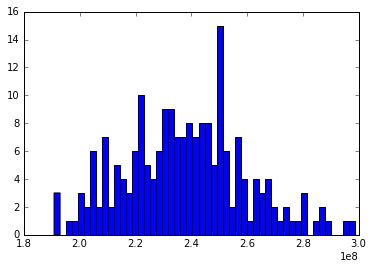

In [746]:
plt.hist(y, bins = 50)
plt.show()